<a href="https://colab.research.google.com/github/hyyoka/DeepLearning-models-Implemetation-from-scratch/blob/main/Multiclass_SVM_classifier_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass SVM classifier from scratch

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy.special as sp
import time
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns

## Support Vector Machine

Starting with binary classification, the goal of SVM is to find out the best separating hyperplane of dataset having two classes. In other words, SVM is to find maximized distance between $w^Tx_i^1 + b= 1, w^Tx_i^2 + b = -1$. Distance is inversely proportional to $\parallel w \parallel$. What we want to solve is:
$$minimize \frac{\parallel w \parallel^2}{2}$$
$$subject\ to\ w^Tx_i^1 + b \geq 1, w^Tx_i^2 + b \leq -1$$



### Soft Margin SVM: Hinge loss
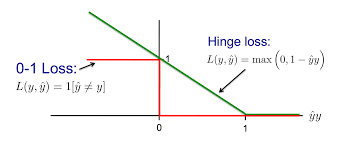

Allow some misclassified points by setting a slack variable $u_i$. Keep in mind that smaller $u_i$ is better. 

$$minimize \frac{\parallel w \parallel^2}{2} + \gamma\sum_i u_i$$
$$subject\ to\ w^Tx_i^1 + b \geq 1-u_i, w^Tx_i^2 + b \leq -1+u_i. u_i \geq 0$$

Using hyperparameter $\gamma$, we can decide whether minimizing $w$ is prioritized or not. 








In [55]:
iris =  sns.load_dataset('iris') 
X= iris.iloc[:,:4]
y = iris.iloc[:,-1]

scal = StandardScaler() #scaling
X = scal.fit_transform(X)

In [56]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

In [57]:
y_train = pd.get_dummies(y_train) #one hot encoding
y_test = pd.get_dummies(y_test)

### Multiclass SVM

Multiclass SVM can be easily decomposed as repeating SVM K times. The goal of each SVM procedure is to classify one-to-rest.   

$$minimize \frac{\parallel w \parallel^2}{2} + \gamma\sum_i u_i\ subject\ to ...$$
$$w^Tx_i^1 + b \geq 1-u_i, y_i=k$$
$$w^Tx_i^2 + b \leq -1+u_i, y_i \neq k$$
$$u_i \geq 0$$
$$for\ each\ class\ k=1,...,K$$

K SVMs can be combined into one big SVM.

$$minimize \sum_k \frac{\parallel w \parallel^2}{2} + \gamma\sum_i\sum_{k \neq y_i} u_i\$$

$$subject\ to ...$$

$$w_{y_i}^Tx_i + b_{y_i} \geq w_{k}^Tx_i + b_{k} +2 -u_i^k$$
$$k \neq y_i$$
$$u_i^k \geq 0$$


At optimality, we have:
$$u_i^k = max[2+(w_{k}^Tx_i + b_{k}) - (w_{y_i}^Tx_i + b_{y_i}), 0]$$

In other words with score:
$$u_i^k = max[2+ score_k - score_{y_i}, 0]$$

So, the total hinge loss is:
$$u_i = \sum_{k \neq y_i}max(2+ score_k - score_{y_i}, 0)$$


```
• Wb: W vector and b vector of size (num class*feat dim + num class).
 ```


In [58]:
## Multi class SVM

def svm_loss(Wb, x, y):

    SVM_loss = 0
    
    n = x.shape[0] # dataset size
    input_dim = x.shape[1]
    num_class = y.shape[0]

    Wb = np.reshape(Wb, (-1, 1))
    b = Wb[-num_class:]
    W = np.reshape(Wb[range(num_class * input_dim)], (num_class, input_dim))


    for xi, yi in zip(x, y):
        yi = np.argmax(yi)
        xi = np.reshape(xi, (-1,1))
        xWb = W.dot(xi) + b

        losses = []
    
        # hinge loss
        losses = [max(0, score[0] - xWb[yi][0] + 1) for score in xWb if score != xWb[yi]]
        SVM_loss += sum(losses)

    return SVM_loss


In [59]:
input_dim = X.shape[1]
num_class = y.shape[0]

wb = np.random.normal(0, 1, (input_dim * num_class + num_class)) 
result = minimize(svm_loss, wb, args=(X_train, y_train))

Wb = result.x